####  Importing Libraries

In [3]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.max.columns",None)


In [4]:
loanData = pd.read_csv("loan.csv",low_memory=False)


#### Droping all the columns which has only null values , duplicate  rows and columns having more than 50% null values

In [5]:
loanData = loanData.dropna(axis=1,how="all")

In [6]:
loanData = loanData.drop_duplicates()

In [7]:
null_value_count = round(100*(loanData.isnull().sum()/len(loanData)), 2)
columns_missing_half_values =null_value_count[null_value_count>50]
loanData = loanData.drop(columns_missing_half_values.index,axis=1)

#### Droping columns which are not having any meaning full insight for analysis

In [8]:
columns_tobe_dropped = ['id','member_id','pymnt_plan','url','zip_code','initial_list_status','policy_code','application_type','acc_now_delinq','delinq_amnt','tax_liens','desc']

loanData = loanData.drop(columns_tobe_dropped,axis=1)

In [9]:
loanData.columns

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length',
       'home_ownership', 'annual_inc', 'verification_status', 'issue_d',
       'loan_status', 'purpose', 'title', 'addr_state', 'dti', 'delinq_2yrs',
       'earliest_cr_line', 'inq_last_6mths', 'open_acc', 'pub_rec',
       'revol_bal', 'revol_util', 'total_acc', 'out_prncp', 'out_prncp_inv',
       'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'chargeoff_within_12_mths',
       'pub_rec_bankruptcies'],
      dtype='object')

#### Cleaning emp_length column with meaningfull values

In [10]:
emp_length_dict = {
    '< 1 year' : 0,
    '1 year' : 1,
    '2 years' : 2,
    '3 years' : 3,
    '4 years' : 4,
    '5 years' : 5,
    '6 years' : 6,
    '7 years' : 7,
    '8 years' : 8,
    '9 years' : 9,
    '10+ years' : 10
}

loanData.emp_length.fillna(0,inplace=True)
loanData = loanData.replace({"emp_length": emp_length_dict })
loanData.emp_length = loanData.emp_length.astype(int)

#### Converting interest rate to float value and changing its data type from object to float

In [11]:
loanData.int_rate=loanData.int_rate.str.strip('%').astype(float)


#### Converting loan term rate to int value and changing its data type from object to int

In [12]:
loanData.term = loanData.term.apply(lambda x :x.split()[0])
loanData.term = loanData.term.astype(int)

#### Populating null values with NONE for home Ownership column

In [13]:
loanData.home_ownership.fillna('NONE',inplace=True)

#### Separating Years from Issue date of loan

In [14]:

issue_date = pd.to_datetime(loanData.issue_d,format="%b-%y")
loanData['Year']= pd.DatetimeIndex(issue_date).year

#### Helper methods to convert  interest_rate,annual_income,installment  into categories of High,Medium,Low

In [15]:
def loan_int_range_segregrator(int_rate):
    if int_rate > 15:
        return 'High'
    elif  15 >= int_rate > 10:
        return 'Medium'
    else:
        return 'Low'
    

loanData['int_rate_category'] = loanData.int_rate.apply(loan_int_range_segregrator)

In [16]:
def annual_income_range_segregrator(income):
    if income > 500000:
        return 'High'
    elif  500000 >= income > 50000:
        return 'Medium'
    else:
        return 'Low'
    

loanData['annual_income_category'] = loanData.annual_inc.apply(annual_income_range_segregrator)


In [17]:
def installement_range_segregrator(installment):
    if installment > 400:
        return 'High'
    elif  400 >= installment > 200:
        return 'Medium'
    else:
        return 'Low'
    

loanData['installment_category'] = loanData.installment.apply(installement_range_segregrator)


In [18]:
def emp_service_segregrator(service_term):
    if service_term > 8 :
        return 'Experienced'
    elif  8 >= service_term > 2:
        return 'Less Experienced'
    else:
        return 'Fresher'
    

loanData['emp_length_category'] = loanData.emp_length.apply(emp_service_segregrator)

In [19]:
def showLabels(ax, d=None):
    plt.margins(0.2, 0.2)
    rects = ax.patches
    i = 0
    locs, labels = plt.xticks() 
    counts = {}
    if not d is None:
        for key, value in d.items():
            counts[str(key)] = value

    # For each bar: Place a label
    for rect in rects:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label. Change to your liking.
        space = 5
        # Vertical alignment for positive values
        va = 'bottom'

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'

        # Use Y value as label and format number with one decimal place
        if d is None:
            label = "{:.1f}%".format(y_value)
        else:
            try:
                label = "{:.1f}%".format(y_value) + "\nof " + str(counts[str(labels[i].get_text())])
            except:
                label = "{:.1f}%".format(y_value)
        
        i = i+1

        # Create annotation
        plt.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va)                      # Vertically align label differently for
                                        # positive and negative values.

In [20]:
def plotLoanStatus(dataframe, by, loanstatus='Charged Off'):
    grp = dataframe.groupby(['loan_status',by])[by].count()
    cnt = dataframe.groupby(by)[by].count()
    percentages = grp.unstack() * 100 / cnt.T
    ax = percentages.loc[loanstatus].plot.bar(color=sns.color_palette('husl', 16))
    ax.set_ylabel('% of loans ' + loanstatus)
    showLabels(ax, grp[loanstatus].to_dict())
    plt.margins(0.2, 0.2)
    plt.tight_layout()
    return ax

In [21]:
def plot_percentages(dataframe, by, sortbyindex=False):
    plt.subplot(1, 2, 1)
    values = (master_loan[by].value_counts(normalize=True)*100)
    if sortbyindex:
        values = values.sort_index()
    ax = values.plot.bar(color=sns.color_palette('husl', 16))
    ax.set_ylabel('% in dataset', fontsize=16)
    ax.set_xlabel(by, fontsize=12)
    showLabels(ax)
    plt.subplot(1, 2, 2)
    values = (master_loan.loc[master_loan['loan_status']=='Charged Off'][by].value_counts(normalize=True)*100)
    if sortbyindex:
        values = values.sort_index()
    ax = values.plot.bar(color=sns.color_palette('husl', 16))
    ax.set_ylabel('% in Charged Off loans', fontsize=16)
    showLabels(ax)

In [22]:
def categoricalBarPlots(df, arr):
    rows = int(len(arr)/2)
    for idx, val in enumerate(arr, start=1):
        plt.subplot(rows, 2, idx)
        ax = df.groupby(val).loan_amnt.count().plot.bar(color=sns.color_palette('husl', 16))
        showLabels(ax)

    plt.tight_layout()

In [23]:
def plot_distribution(dataframe, col):
    plt.figure(figsize=(15,5))
    plt.subplot(1, 2, 1)
    ax = sns.distplot(dataframe[col])
    plt.subplot(1, 2, 2)
    sns.boxplot(x=dataframe[col], y=dataframe['loan_status'], data=dataframe)
    plt.show()

#### looking for distinct loan status

In [24]:
loanData.loan_status.unique()

array(['Fully Paid', 'Charged Off', 'Current'], dtype=object)

#### Fully Paid Loan is 83% ,Defaulter Loan is 14% and Current Loan is 3% of the Total Loan DataSet

In [25]:
loanData.loan_status.value_counts()

Fully Paid     32950
Charged Off     5627
Current         1140
Name: loan_status, dtype: int64

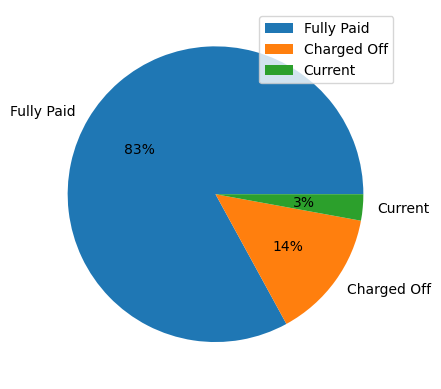

In [26]:
loan_status_data = loanData.loan_status.value_counts()
plt.pie(loan_status_data,labels=loan_status_data.keys() ,autopct='%.0f%%')
plt.legend()
plt.show()

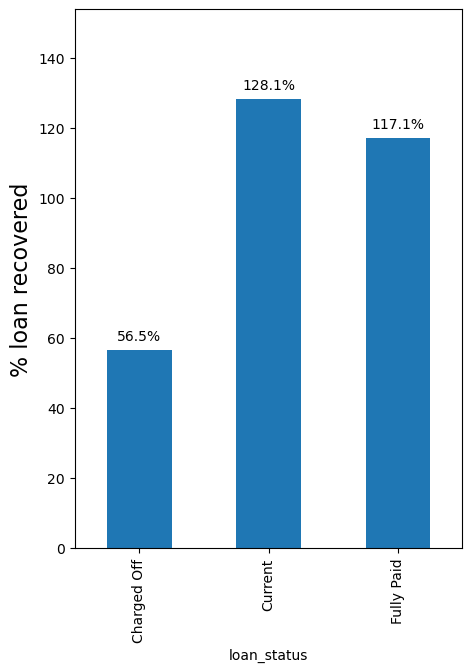

In [27]:
plt.figure(figsize=(5,7))
ax = (loanData.groupby('loan_status').total_pymnt.sum() * 100 / loanData.groupby('loan_status').loan_amnt.sum()).plot.bar()
ax.set_ylabel('% loan recovered', fontsize=16)
plt.margins(0.2, 0.2)
showLabels(ax)

#### 36 month loan tenure is  73% ,60 months loan term is 27% 

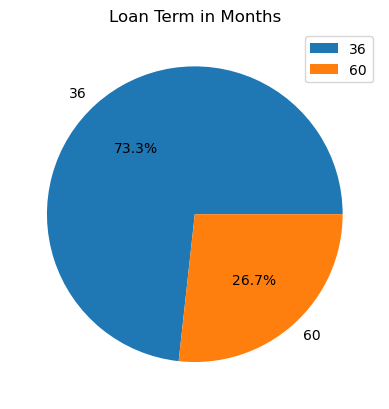

In [28]:
term_data = loanData.term.value_counts()
plt.pie(term_data,labels=term_data.keys(),autopct='%.1f%%')
plt.title("Loan Term in Months")
plt.legend()
plt.show()

#### Separating Deafulter Loan  and Fully Paid Loan DataSet

In [29]:

defaulterdata = loanData[loanData.loan_status == 'Charged Off']
fullyPaiddata = loanData[loanData.loan_status == 'Fully Paid']

#### Analyzing Income, Interest rate , Installment  in ['Low','Medium','High'] category

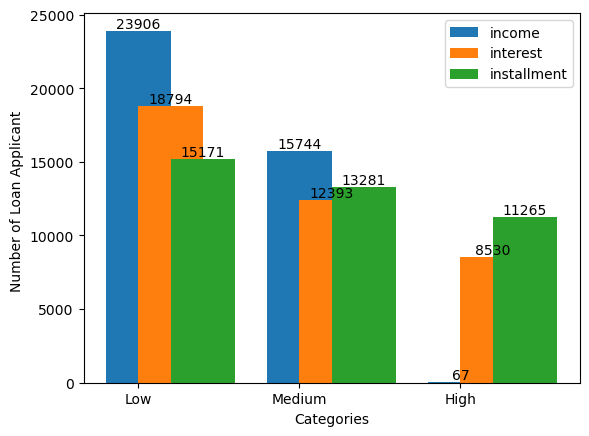

In [30]:

categories = ['Low','Medium','High']
income_categories = loanData.annual_income_category.value_counts()
interest_Categories = loanData.int_rate_category.value_counts()
installment_Categories = loanData.installment_category.value_counts()

X_axis = np.arange(len(categories))

ax = plt.bar(X_axis , income_categories, 0.4, label = 'income')
plt.bar_label(ax)
ax = plt.bar(X_axis + 0.2, interest_Categories, 0.4, label = 'interest')
plt.bar_label(ax)
ax = plt.bar(X_axis +0.4, installment_Categories, 0.4, label = 'installment')
plt.bar_label(ax)
  
    
plt.xticks(X_axis, categories)
plt.xlabel("Categories")
plt.ylabel("Number of Loan Applicant ")
plt.legend()
plt.show()


#### Impact of Employement Tenure on Loan Repayment

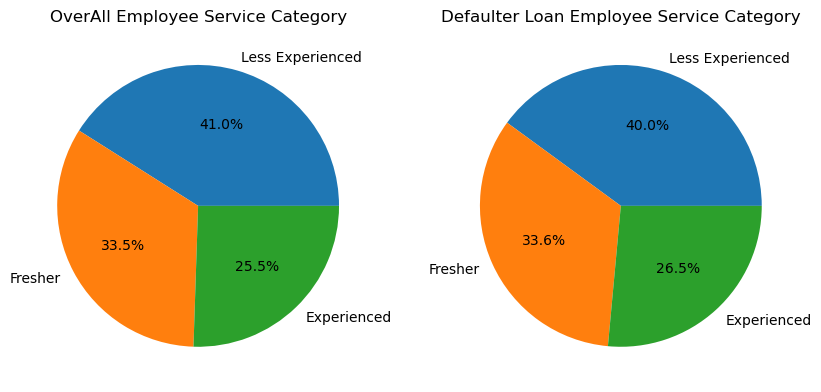

In [31]:

plt.figure(figsize=(10,10))
data = loanData.emp_length_category.value_counts()

plt.subplot(1,2,1)
plt.pie(data,labels=data.keys(),autopct='%.1f%%')
plt.title("OverAll Employee Service Category")

default_data =defaulterdata.emp_length_category.value_counts()
plt.subplot(1,2,2)
plt.pie(default_data,labels=default_data.keys(),autopct='%.1f%%')
plt.title("Defaulter Loan Employee Service Category")
plt.show()


#### Defaulters list is tentatively very high where DTI range is between 6 to 24

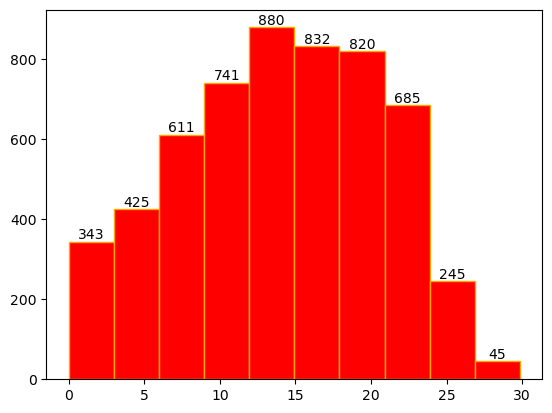

In [32]:
counts, edges, bars= plt.hist(defaulterdata.dti,bins=10,edgecolor='Orange',color='red')
plt.bar_label(bars)
plt.show()

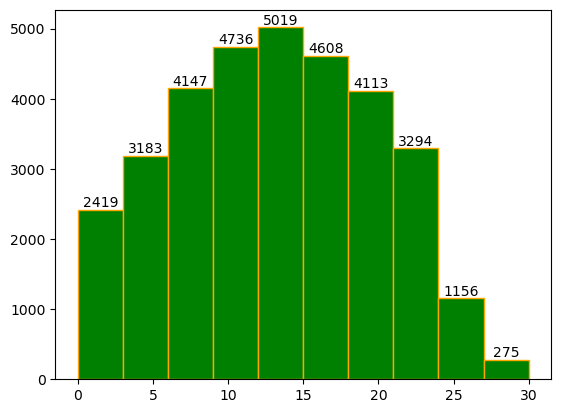

In [33]:
counts, edges, bars = plt.hist(fullyPaiddata.dti,bins=10,edgecolor='Orange',color='green')

plt.bar_label(bars)
plt.show()

#### On An Average Charged Off loan amount lies in between 5000 to 15000

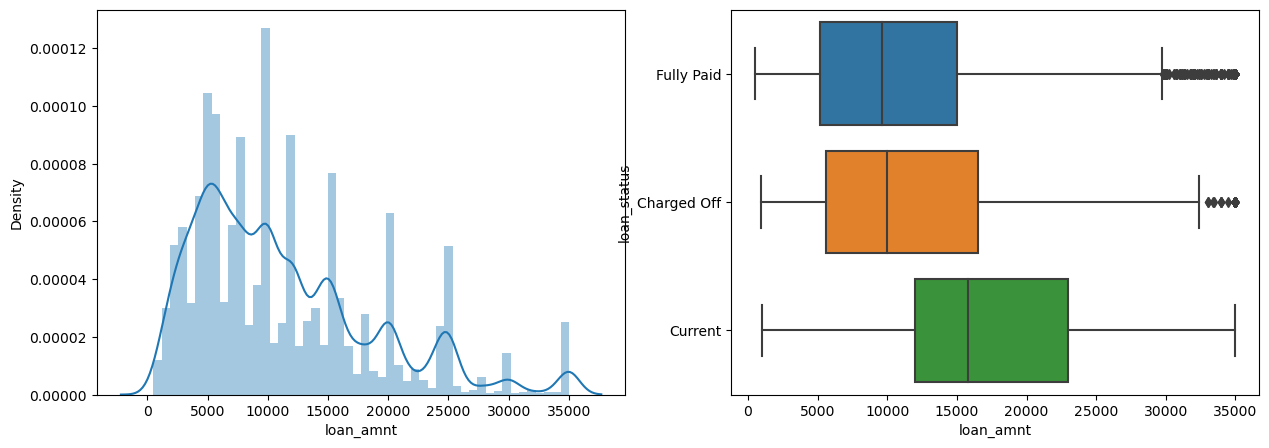

In [34]:

plot_distribution(loanData, 'loan_amnt')


#### Analyzing the impact of Home Ownership for defaulter loan applicants vs Over all Loan Applicant

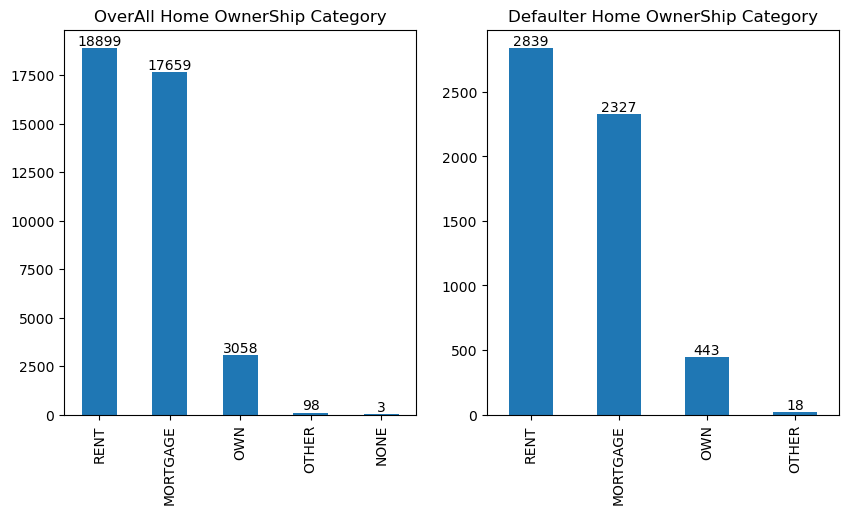

In [35]:
plt.figure(figsize=(10,5))
data = loanData.home_ownership.value_counts()

plt.subplot(1,2,1)
ax=data.plot.bar()
ax.bar_label(ax.containers[0])
plt.title("OverAll Home OwnerShip Category")

default_data =defaulterdata.home_ownership.value_counts()
plt.subplot(1,2,2)
ax=default_data.plot.bar()
ax.bar_label(ax.containers[0])
plt.title("Defaulter Home OwnerShip Category")
plt.show()

#### Finding Relationship between Interest Rate with annual income category for all the loan status

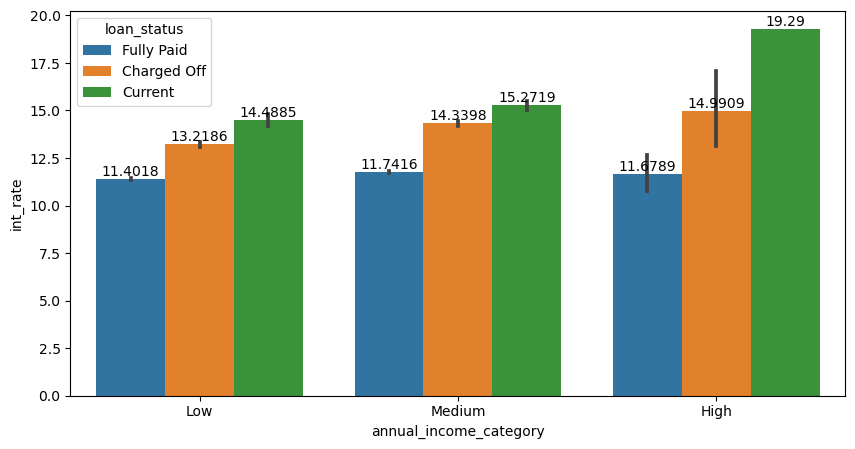

In [36]:
plt.figure(figsize=(10,5))
ax =sns.barplot(x='annual_income_category', y='int_rate', hue="loan_status", data=loanData, estimator=np.mean)
for container in ax.containers:
       plt.bar_label(container) 

plt.show()

#### Most of the defaulter loan is sanctioned under 40000 and loan applicant income lies between 0 to 250K

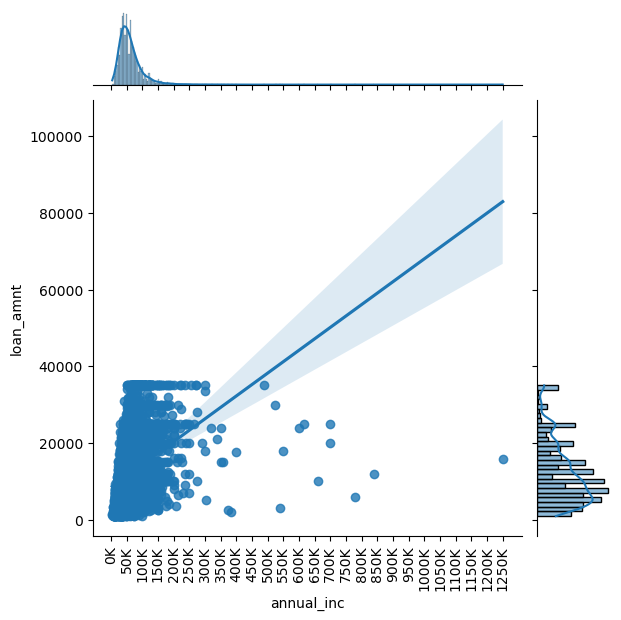

In [37]:

sns.jointplot(defaulterdata,x="annual_inc",y="loan_amnt",kind="reg")
ticks = np.arange(0,1300000,50000)
label = ["{}K".format(i // 1000) for i in ticks]
plt.xticks(ticks,label,rotation = 90)
plt.show()

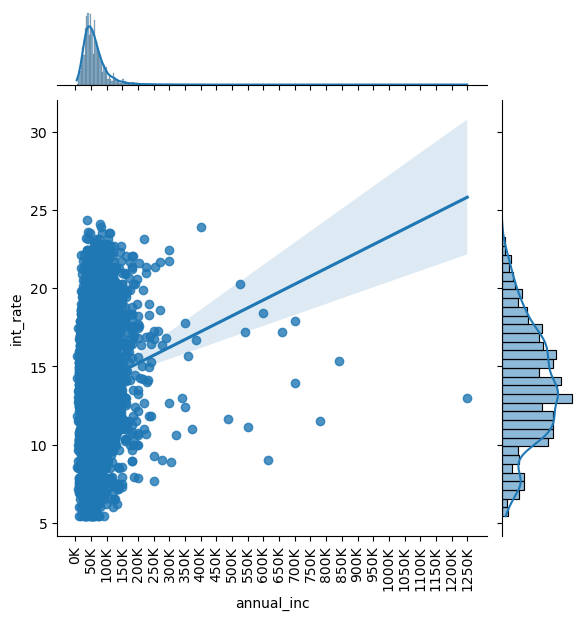

In [38]:
sns.jointplot(defaulterdata,x="annual_inc",y="int_rate",kind="reg")
ticks = np.arange(0,1300000,50000)
label = ["{}K".format(i // 1000) for i in ticks]
plt.xticks(ticks,label,rotation = 90)
plt.show()

In [39]:
pd.pivot_table(data= loanData,values=['annual_inc','dti','loan_amnt','int_rate'],index=['loan_status'],aggfunc='mean')

,annual_inc,dti,int_rate,loan_amnt
loan_status,,,,
Charged Off,62427.298034,14.000624,13.820432,12104.385108
Current,75430.665105,14.750009,15.031465,17053.991228
Fully Paid,69862.503328,13.148421,11.609761,10866.455994


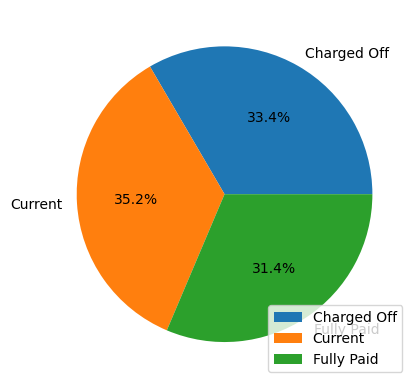

In [40]:

data = loanData.groupby(by='loan_status')['dti'].mean()
plt.pie(data,labels=data.keys(),autopct='%.1f%%')
plt.legend()
plt.show()


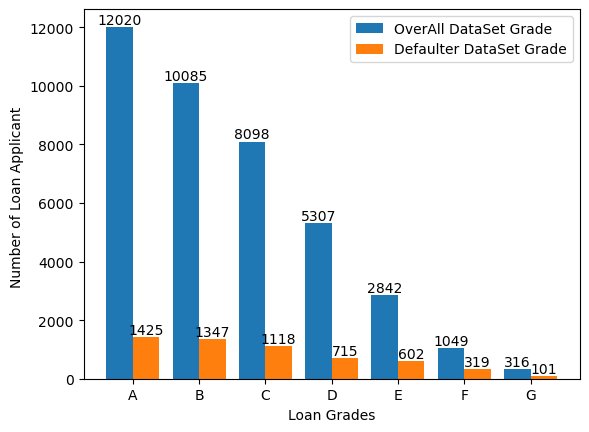

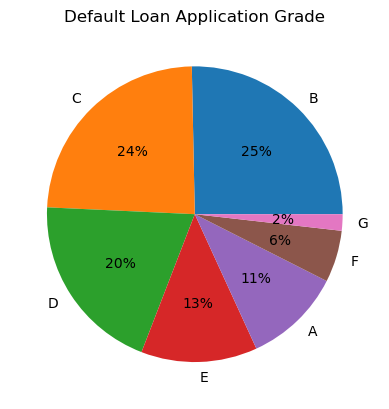

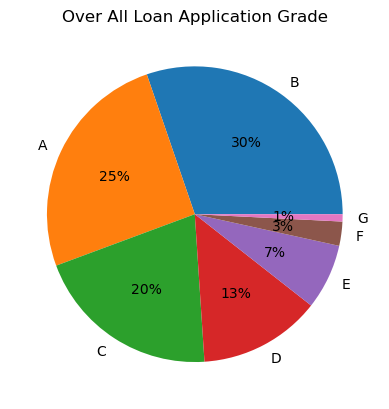

In [41]:
categories = loanData.grade.unique()
categories.sort()
OverAll_loandata_Grade = loanData.grade.value_counts()
Default_loandatta_Grade = defaulterdata.grade.value_counts()


X_axis = np.arange(len(categories))

ax = plt.bar(X_axis-0.2 , OverAll_loandata_Grade, 0.4, label = 'OverAll DataSet Grade')
plt.bar_label(ax)
ax=plt.bar(X_axis + 0.2, Default_loandatta_Grade, 0.4, label = 'Defaulter DataSet Grade')
plt.bar_label(ax)

   
plt.xticks(X_axis, categories)
plt.xlabel("Loan Grades")
plt.ylabel("Number of Loan Applicant ")
plt.legend()
plt.show()


plt.pie(defaulterdata.grade.value_counts(),labels=defaulterdata.grade.value_counts().keys(),autopct='%.0f%%')
plt.title("Default Loan Application Grade")
plt.show()

plt.pie(loanData.grade.value_counts(),labels=loanData.grade.value_counts().keys(),autopct='%.0f%%')
plt.title("Over All Loan Application Grade")
plt.show()



In [42]:
 loanData.groupby("loan_status")["int_rate","annual_inc"].mean()

,int_rate,annual_inc
loan_status,,
Charged Off,13.820432,62427.298034
Current,15.031465,75430.665105
Fully Paid,11.609761,69862.503328


In [43]:

plt.figure(figsize=(15,5))


<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

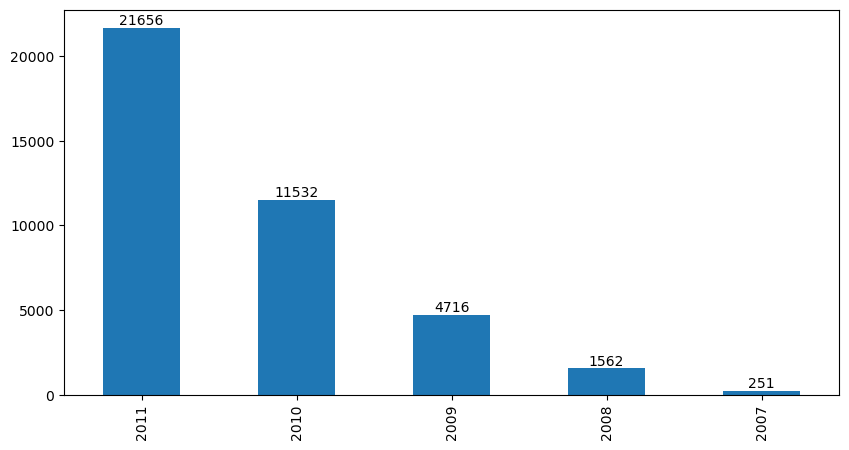

In [44]:
plt.figure(figsize=(10,5))
ax=loanData.Year.value_counts().plot.bar()
plt.bar_label(ax.containers[0])

plt.show()

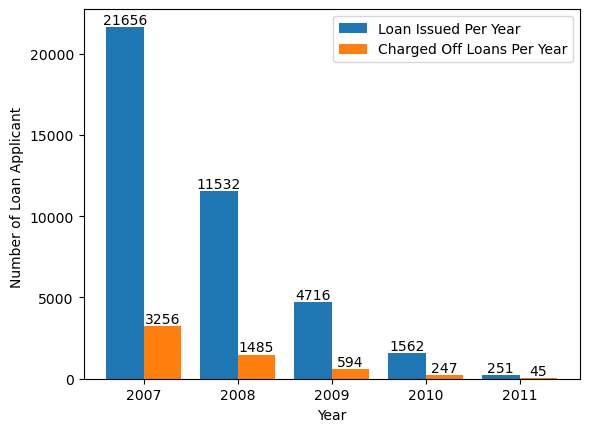

In [45]:


categories = loanData.Year.unique()
categories.sort()
OverAll_loandata = loanData.Year.value_counts()
Default_loandata= defaulterdata.Year.value_counts()


X_axis = np.arange(len(categories))

ax = plt.bar(X_axis-0.2 , OverAll_loandata, 0.4, label = 'Loan Issued Per Year')
plt.bar_label(ax)
ax=plt.bar(X_axis + 0.2, Default_loandata, 0.4, label = 'Charged Off Loans Per Year')
plt.bar_label(ax)

   
plt.xticks(X_axis, categories)
plt.xlabel("Year")
plt.ylabel("Number of Loan Applicant ")
plt.legend()
plt.show()



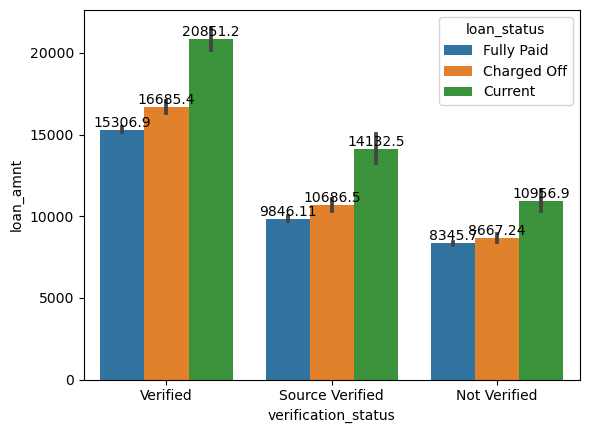

In [46]:
ax=sns.barplot(x='verification_status', y='loan_amnt', hue="loan_status", data=loanData, estimator=np.mean)
for container in ax.containers:
    plt.bar_label(container)
plt.show()

#### Finding Correlation between few parameters of the Loan Data Set

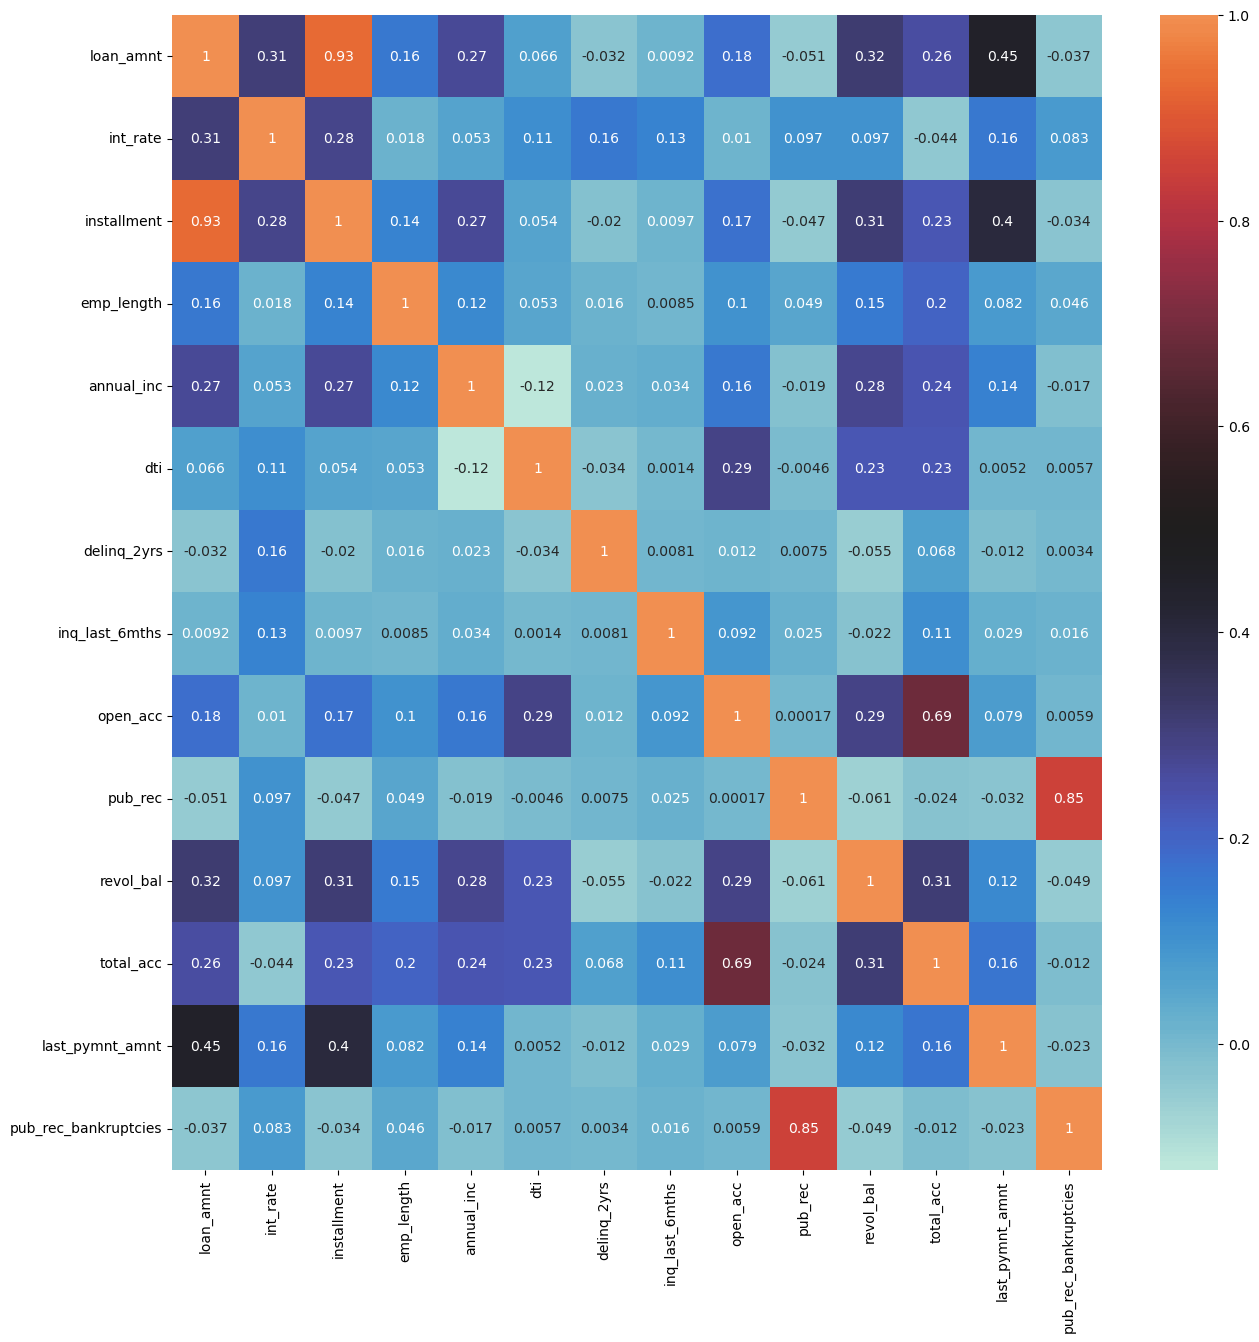

In [47]:
plt.figure(figsize=(15,15))
cont_var= ['loan_amnt', 'int_rate', 'installment',
       'emp_length', 'annual_inc',
       'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util',
       'total_acc', 'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d',
       'pub_rec_bankruptcies']
corr = loanData[cont_var].corr()
sns.heatmap(corr, annot=True, center=0.5)
plt.show()

#### Analyzing MultiVariant columns 

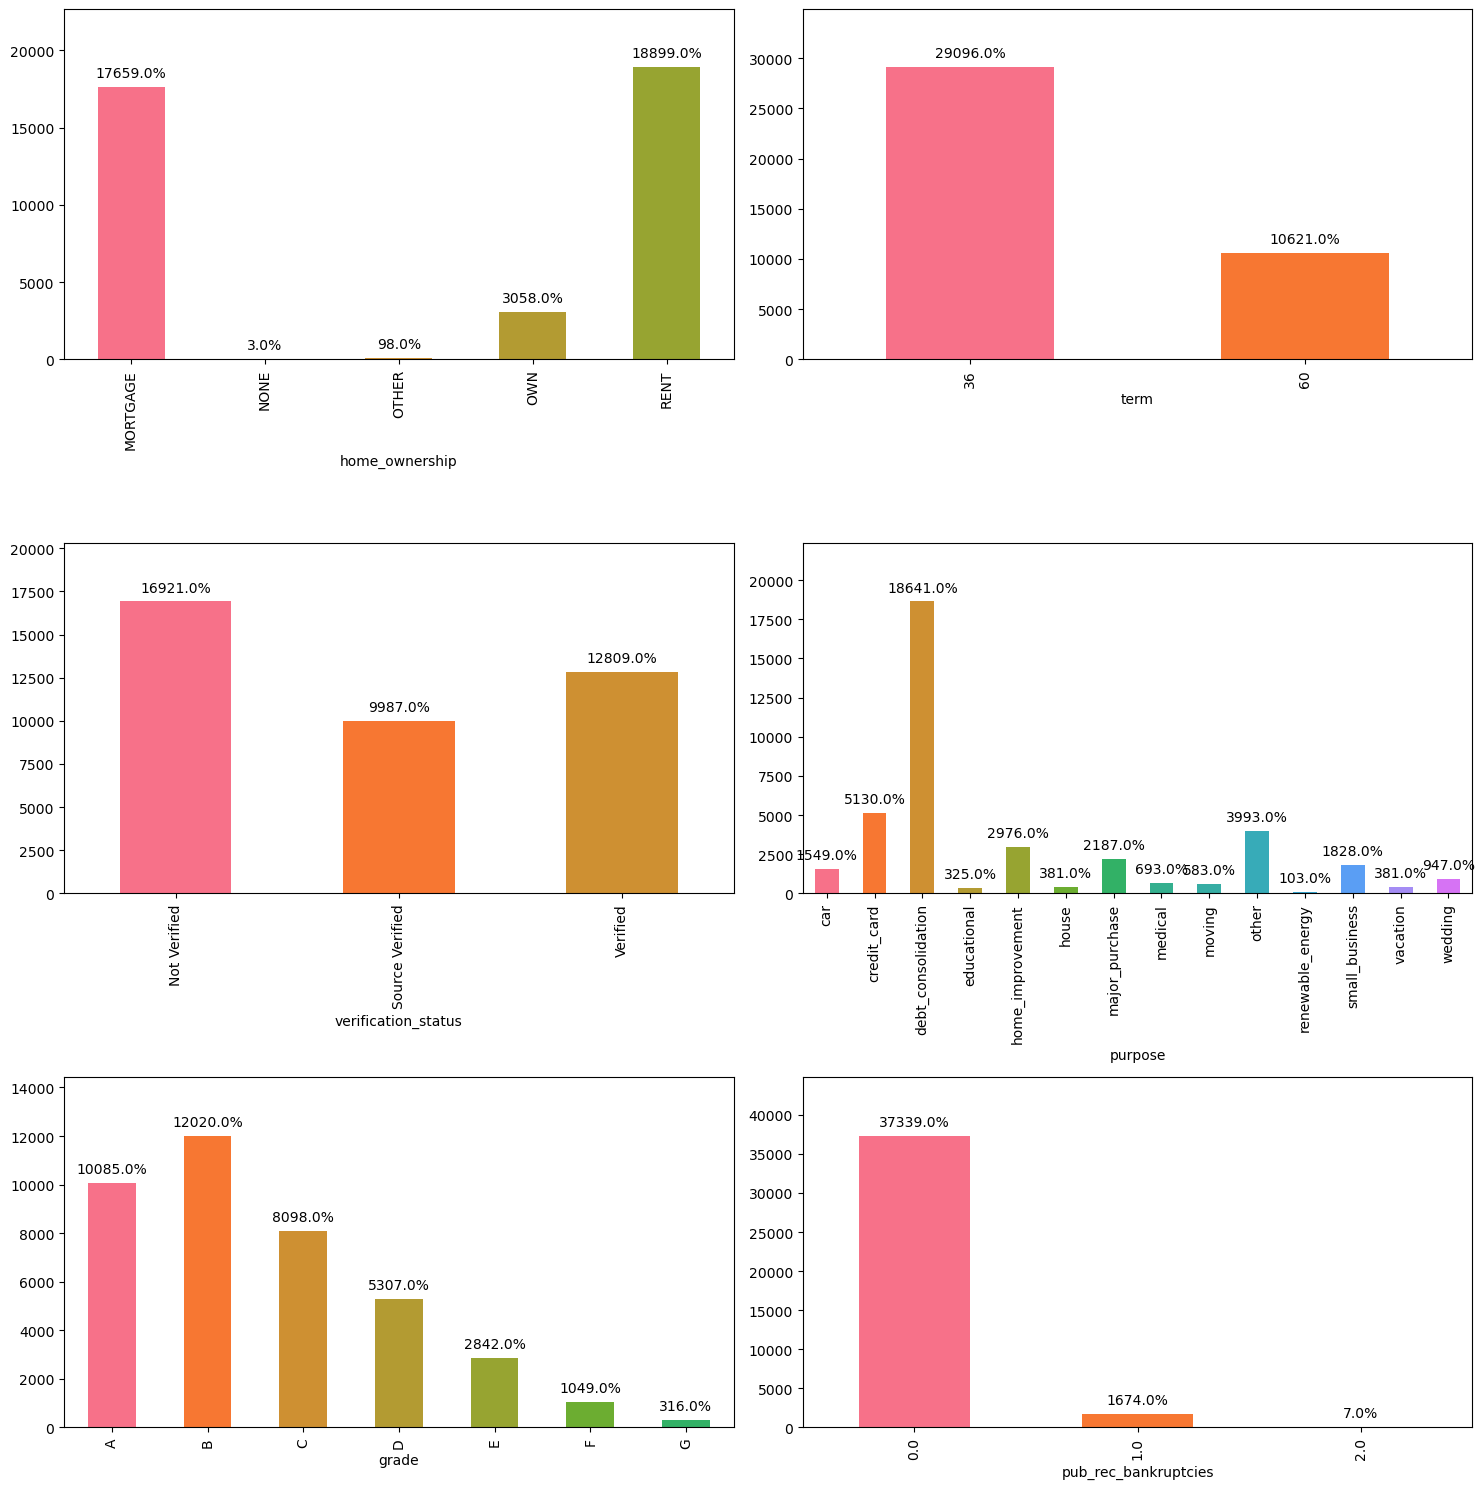

In [48]:
plt.figure(figsize=(15,15))

categoricalBarPlots(loanData, ['home_ownership', 'term', 'verification_status', 'purpose', 'grade', 'pub_rec_bankruptcies'])

#### Interest Rate  Vs Loan Grade relationship

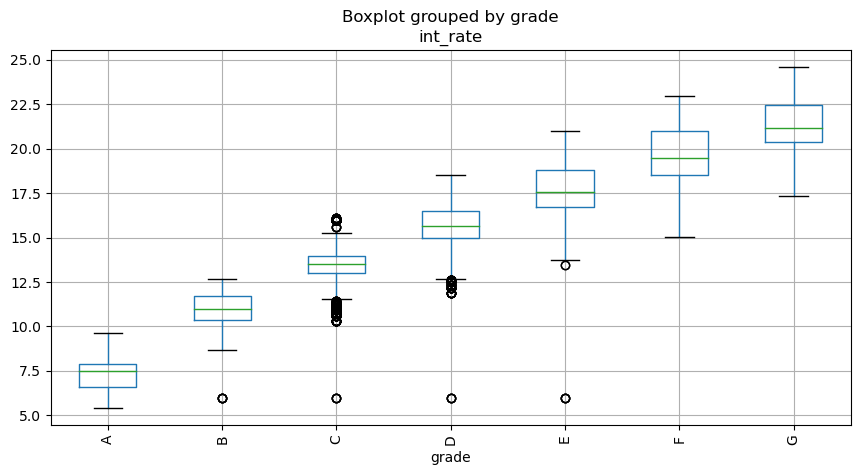

In [49]:
fig, ax = plt.subplots(figsize=(10,5))
loanData.boxplot(column=['int_rate'],by='grade', ax=ax, rot=90)
plt.show()

#### Change in pattern on increase of Loan Interest Rate

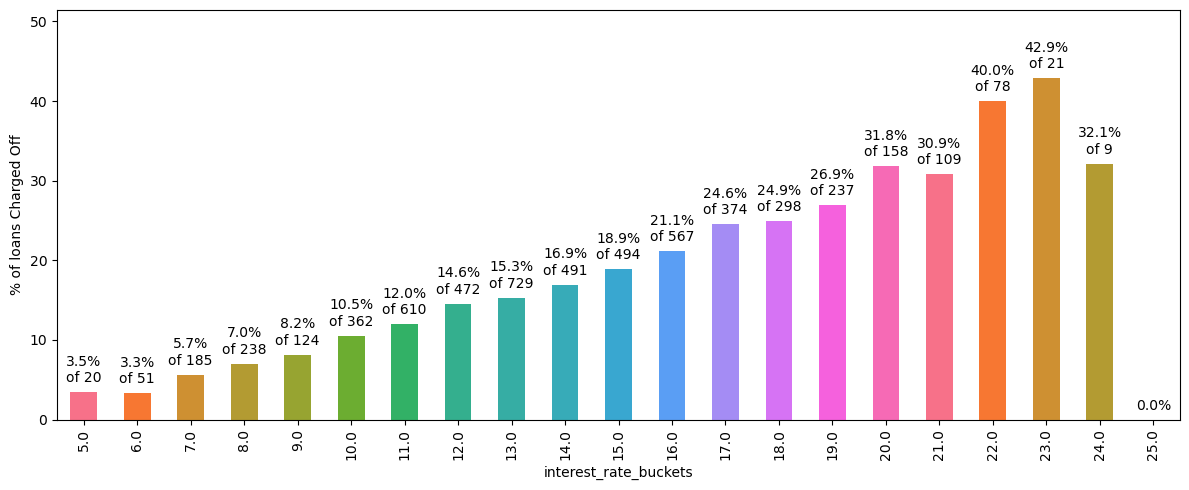

In [50]:
loanData['interest_rate_buckets'] = round(loanData['int_rate'])
plt.figure(figsize=(12,5))
plotLoanStatus(loanData, 'interest_rate_buckets')

plt.show()